# Solution of the traveling salesman problem using the standard and the simplified versions of the rollout algorithms

This is an animation of the solution of the traveling salesman problem using the standard and the simplified versions of the rollout algorithms, as described in the course textbook. The base heuristic is the nearest neighbor heuristic.

Copyright @ Dimitri P. Bertsekas, Yuchao Li

Nearest Neighbor Heuristic Animation:


Rollout Algorithm Animation:


Simplified Rollout Algorithm Animation (max 3 candidates):


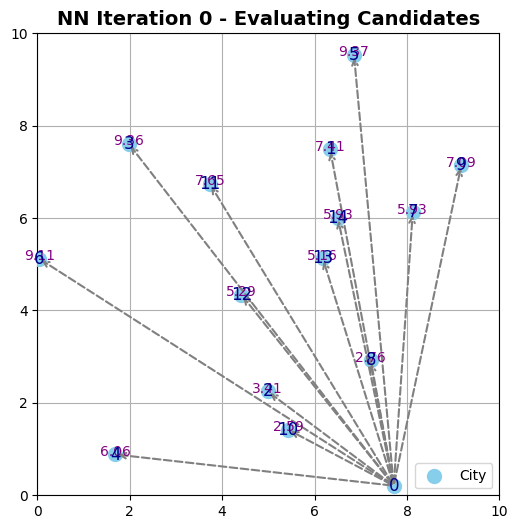

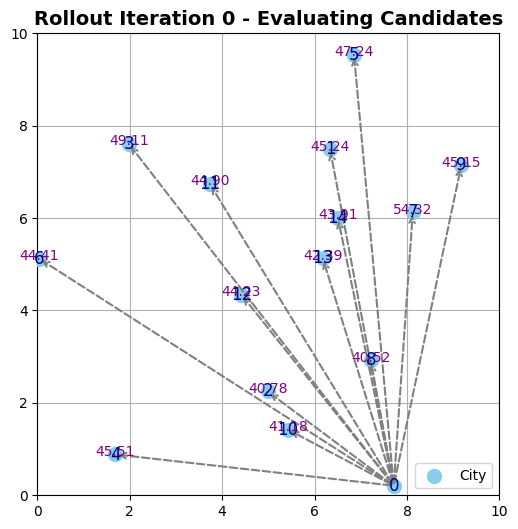

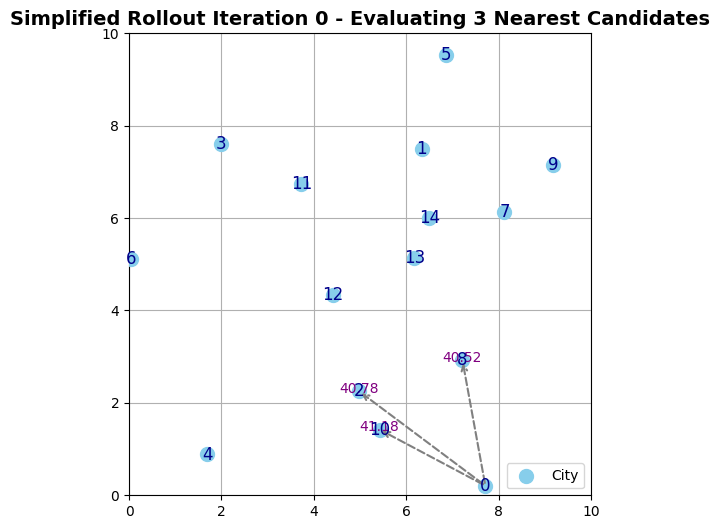

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

# =====================================
# Parameters and Area Setup
# =====================================
L = 10  # Side length of the square where cities are generated.
num_cities = 15
np.random.seed(10)  # For reproducibility
# =====================================
# Helper Functions
# =====================================
def compute_distance_matrix(cities):
    """Compute the Euclidean distance between each pair of cities."""
    n = len(cities)
    d = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            d[i, j] = np.linalg.norm(cities[i] - cities[j])
    return d

def complete_tour_nn(partial, remaining, distances):
    """
    Given a partial tour (list of visited city indices) and the remaining cities,
    complete the tour using a nearest-neighbor heuristic.

    Returns the complete tour (i.e. the partial tour extended by the NN rule, ending with a return to city 0).
    """
    tour = partial.copy()
    rem = list(remaining)
    current = tour[-1]
    while rem:
        next_city = min(rem, key=lambda c: distances[current, c])
        tour.append(next_city)
        rem.remove(next_city)
        current = next_city
    tour.append(tour[0])  # Return to origin.
    return tour

def tour_cost(tour, distances):
    """Compute the total tour cost for a given tour (including the return to the origin)."""
    cost = 0
    for i in range(len(tour)-1):
        cost += distances[tour[i], tour[i+1]]
    return cost

def partial_tour_cost(partial, distances):
    """
    Compute the cost of the current partial tour,
    i.e. the sum of distances along the edges already chosen (excluding any return edge).
    """
    cost = 0
    for i in range(len(partial)-1):
        cost += distances[partial[i], partial[i+1]]
    return cost

# =====================================
# Problem Setup
# =====================================

cities = L * np.random.rand(num_cities, 2)  # Cities in [0,L]×[0,L]
distances = compute_distance_matrix(cities)

# =====================================
# Animation for Nearest Neighbor Heuristic
# =====================================
iterations_nn = []
start_city = 0
partial_tour_nn = [start_city]
remaining_nn = set(range(num_cities)) - {start_city}
iteration_number_nn = 0

while remaining_nn:
    candidates = []
    current_city = partial_tour_nn[-1]
    for candidate in sorted(remaining_nn):
        d = distances[current_city, candidate]
        candidates.append((candidate, d))
    best_candidate, best_distance = min(candidates, key=lambda x: x[1])
    iterations_nn.append({
         'iteration': iteration_number_nn,
         'partial_tour': partial_tour_nn.copy(),
         'candidates': candidates,  # List of (candidate index, distance)
         'chosen_candidate': best_candidate,
         'chosen_distance': best_distance,
         'is_final': False
    })
    partial_tour_nn.append(best_candidate)
    remaining_nn.remove(best_candidate)
    iteration_number_nn += 1

iterations_nn.append({  # Final iteration: show return edge and complete tour.
    'iteration': iteration_number_nn,
    'partial_tour': partial_tour_nn.copy(),
    'is_final': True
})

fig_nn, ax_nn = plt.subplots(figsize=(6,6))
frames_per_iter_nn = 2
total_frames_nn = len(iterations_nn) * frames_per_iter_nn

def update_nn(frame):
    ax_nn.clear()
    iter_idx = frame // frames_per_iter_nn
    phase = frame % frames_per_iter_nn
    data = iterations_nn[iter_idx]

    # Draw cities and labels.
    ax_nn.scatter(cities[:,0], cities[:,1], c='skyblue', s=100, zorder=3, label='City')
    for i, (x,y) in enumerate(cities):
        ax_nn.text(x, y, str(i), color='darkblue', fontsize=12, ha='center', va='center', zorder=4)

    if len(data['partial_tour']) > 1:
        pt_coords = cities[np.array(data['partial_tour'])]
        ax_nn.plot(pt_coords[:,0], pt_coords[:,1], 'k-', linewidth=2, label='Partial Tour')

    if data.get('is_final', False):
        last_city = data['partial_tour'][-1]
        origin = data['partial_tour'][0]
        last_pos = cities[last_city]
        origin_pos = cities[origin]
        if phase == 0:
            ax_nn.annotate("",
                           xy=origin_pos, xycoords='data',
                           xytext=last_pos, textcoords='data',
                           arrowprops=dict(arrowstyle="->", linestyle="--", color="gray", lw=1.5))
            phase_info = "Return Edge"
            title_text = f"NN Final Phase - {phase_info}"
            ax_nn.set_title(title_text, fontsize=14, fontweight='bold')
        else:
            complete_tour = data['partial_tour'] + [origin]
            complete_coords = cities[np.array(complete_tour)]
            ax_nn.plot(complete_coords[:,0], complete_coords[:,1], 'r-', linewidth=3, label="Complete Tour")
            ax_nn.scatter(origin_pos[0], origin_pos[1], s=200, marker='*', c='red',
                          edgecolors='black', linewidths=1.5, zorder=5, label='Origin')
            ax_nn.text(origin_pos[0], origin_pos[1]+0.04, "Origin", color='red', fontsize=12, fontweight='bold', ha='center')
            total_cost_nn = tour_cost(complete_tour, distances)
            ax_nn.text(0.5, 0.95, f"Total Cost (NN): {total_cost_nn:.2f}", transform=ax_nn.transAxes,
                       fontsize=14, color='red', ha='center')
            phase_info = "Complete Tour"
            title_text = f"NN Final Phase - {phase_info}"
            ax_nn.set_title(title_text, fontsize=14, fontweight='bold')
    else:
        current_city = data['partial_tour'][-1]
        current_pos = cities[current_city]
        if phase == 0:
            for candidate, d in data['candidates']:
                candidate_pos = cities[candidate]
                ax_nn.annotate("",
                               xy=candidate_pos, xycoords='data',
                               xytext=current_pos, textcoords='data',
                               arrowprops=dict(arrowstyle="->", linestyle="--", color="gray", lw=1.5))
                ax_nn.text(candidate_pos[0], candidate_pos[1]-0.03, f"{d:.2f}",
                           color='purple', fontsize=10, ha='center')
            phase_info = "Evaluating Candidates"
        else:
            chosen = data['chosen_candidate']
            chosen_pos = cities[chosen]
            ax_nn.annotate("",
                           xy=chosen_pos, xycoords='data',
                           xytext=current_pos, textcoords='data',
                           arrowprops=dict(arrowstyle="->", linestyle="-", color="red", lw=3))
            ax_nn.scatter(chosen_pos[0], chosen_pos[1], s=200, marker='*', c='red',
                          edgecolors='black', linewidths=1.5, zorder=5, label='Chosen City')
            ax_nn.text(chosen_pos[0], chosen_pos[1]+0.04, f"Chosen: {chosen}", color='red',
                       fontsize=12, fontweight='bold', ha='center')
            phase_info = f"Chosen candidate: {chosen} (dist: {data['chosen_distance']:.2f})"
        title_text = f"NN Iteration {iter_idx} - {phase_info}"
        ax_nn.set_title(title_text, fontsize=14, fontweight='bold')

    ax_nn.legend(loc='lower right')
    ax_nn.set_xlim(0, L)
    ax_nn.set_ylim(0, L)
    ax_nn.set_aspect('equal')
    ax_nn.grid(True)

ani_nn = FuncAnimation(fig_nn, update_nn, frames=total_frames_nn, interval=1500, repeat=False)

# =====================================
# Animation for Rollout Algorithm
# =====================================
iterations_rollout = []
start_city = 0
partial_tour_rollout = [start_city]
remaining_rollout = set(range(num_cities)) - {start_city}
iteration_number_rollout = 0

while remaining_rollout:
    candidates = []
    for candidate in sorted(remaining_rollout):
        new_partial = partial_tour_rollout + [candidate]
        new_remaining = remaining_rollout - {candidate}
        candidate_tour = complete_tour_nn(new_partial.copy(), new_remaining, distances)
        candidate_cost = tour_cost(candidate_tour, distances)
        candidates.append((candidate, candidate_cost, candidate_tour))
    best_candidate, best_cost, best_tour = min(candidates, key=lambda x: x[1])
    iterations_rollout.append({
         'iteration': iteration_number_rollout,
         'partial_tour': partial_tour_rollout.copy(),
         'candidates': candidates,
         'chosen_candidate': best_candidate,
         'chosen_tour': best_tour,
         'chosen_cost': best_cost,
         'is_final': False
    })
    partial_tour_rollout.append(best_candidate)
    remaining_rollout.remove(best_candidate)
    iteration_number_rollout += 1

iterations_rollout.append({
    'iteration': iteration_number_rollout,
    'partial_tour': partial_tour_rollout.copy(),
    'is_final': True
})

fig_rollout, ax_rollout = plt.subplots(figsize=(6,6))
frames_per_iter = 2
total_frames_rollout = len(iterations_rollout) * frames_per_iter

def update_rollout(frame):
    ax_rollout.clear()
    iter_idx = frame // frames_per_iter
    phase = frame % frames_per_iter
    data = iterations_rollout[iter_idx]

    ax_rollout.scatter(cities[:,0], cities[:,1], c='skyblue', s=100, zorder=3, label='City')
    for i, (x,y) in enumerate(cities):
        ax_rollout.text(x, y, str(i), color='darkblue', fontsize=12, ha='center', va='center', zorder=4)
    if len(data['partial_tour']) > 1:
        pt_coords = cities[np.array(data['partial_tour'])]
        ax_rollout.plot(pt_coords[:,0], pt_coords[:,1], 'k-', linewidth=2, label='Partial Tour')

    if data.get('is_final', False):
        if phase == 0:
            last_city = data['partial_tour'][-1]
            origin = data['partial_tour'][0]
            last_pos = cities[last_city]
            origin_pos = cities[origin]
            ax_rollout.annotate("",
                                xy=origin_pos, xycoords='data',
                                xytext=last_pos, textcoords='data',
                                arrowprops=dict(arrowstyle="->", linestyle="--", color="gray", lw=1.5))
            phase_info = "Evaluating Return to Origin"
            title_text = f"Rollout Final Phase - {phase_info}"
            ax_rollout.set_title(title_text, fontsize=14, fontweight='bold')
        else:
            complete_tour = data['partial_tour'] + [data['partial_tour'][0]]
            complete_coords = cities[np.array(complete_tour)]
            ax_rollout.plot(complete_coords[:,0], complete_coords[:,1], 'r-', linewidth=3, label="Complete Tour")
            origin = data['partial_tour'][0]
            origin_pos = cities[origin]
            ax_rollout.scatter(origin_pos[0], origin_pos[1], s=200, marker='*', c='red',
                               edgecolors='black', linewidths=1.5, zorder=5, label='Origin')
            ax_rollout.text(origin_pos[0], origin_pos[1]+0.04, "Origin", color='red', fontsize=12, fontweight='bold', ha='center')
            total_cost_rollout = tour_cost(complete_tour, distances)
            ax_rollout.text(0.5, 0.95, f"Total Cost (Rollout): {total_cost_rollout:.2f}", transform=ax_rollout.transAxes,
                            fontsize=14, color='red', ha='center')
            phase_info = "Complete Tour"
            title_text = f"Rollout Final Phase - {phase_info}"
            ax_rollout.set_title(title_text, fontsize=14, fontweight='bold')
    else:
        current_city = data['partial_tour'][-1]
        current_pos = cities[current_city]
        if phase == 0:
            curr_partial_cost = partial_tour_cost(data['partial_tour'], distances)
            for candidate, cost, candidate_tour in data['candidates']:
                candidate_pos = cities[candidate]
                ax_rollout.annotate("",
                                    xy=candidate_pos, xycoords='data',
                                    xytext=current_pos, textcoords='data',
                                    arrowprops=dict(arrowstyle="->", linestyle="--", color="gray", lw=1.5))
                additional_cost = cost - curr_partial_cost
                ax_rollout.text(candidate_pos[0], candidate_pos[1]-0.03, f"{additional_cost:.2f}",
                                color='purple', fontsize=10, ha='center')
            phase_info = "Evaluating Candidates"
        else:
            chosen = data['chosen_candidate']
            chosen_pos = cities[chosen]
            ax_rollout.annotate("",
                                xy=chosen_pos, xycoords='data',
                                xytext=current_pos, textcoords='data',
                                arrowprops=dict(arrowstyle="->", linestyle="-", color="red", lw=3))
            ax_rollout.scatter(chosen_pos[0], chosen_pos[1], s=200, marker='*', c='red',
                                edgecolors='black', linewidths=1.5, zorder=5, label='Chosen City')
            ax_rollout.text(chosen_pos[0], chosen_pos[1]+0.04, f"Chosen: {chosen}",
                            color='red', fontsize=12, fontweight='bold', ha='center')
            phase_info = f"Chosen candidate: {chosen} (cost: {data['chosen_cost']:.2f})"
        title_text = f"Rollout Iteration {iter_idx} - {phase_info}"
        ax_rollout.set_title(title_text, fontsize=14, fontweight='bold')

    ax_rollout.legend(loc='lower right')
    ax_rollout.set_xlim(0, L)
    ax_rollout.set_ylim(0, L)
    ax_rollout.set_aspect('equal')
    ax_rollout.grid(True)

ani_rollout = FuncAnimation(fig_rollout, update_rollout, frames=total_frames_rollout, interval=1500, repeat=False)

# =====================================
# Animation for Simplified Rollout Algorithm
# (Only up to 3 nearest remaining cities are considered at each stage)
# =====================================
iterations_simplified = []
start_city = 0
partial_tour_simplified = [start_city]
remaining_simplified = set(range(num_cities)) - {start_city}
iteration_number_simplified = 0

while remaining_simplified:
    candidates = []
    current_city = partial_tour_simplified[-1]
    # Consider at most 3 nearest remaining cities.
    remaining_sorted = sorted(list(remaining_simplified), key=lambda c: distances[current_city, c])
    candidate_subset = remaining_sorted[:3]
    for candidate in candidate_subset:
        new_partial = partial_tour_simplified + [candidate]
        new_remaining = remaining_simplified - {candidate}
        candidate_tour = complete_tour_nn(new_partial.copy(), new_remaining, distances)
        candidate_cost = tour_cost(candidate_tour, distances)
        candidates.append((candidate, candidate_cost, candidate_tour))
    best_candidate, best_cost, best_tour = min(candidates, key=lambda x: x[1])
    iterations_simplified.append({
         'iteration': iteration_number_simplified,
         'partial_tour': partial_tour_simplified.copy(),
         'candidates': candidates,  # Only from the candidate_subset (max 3 candidates)
         'chosen_candidate': best_candidate,
         'chosen_tour': best_tour,
         'chosen_cost': best_cost,
         'is_final': False,
         'candidate_subset': candidate_subset
    })
    partial_tour_simplified.append(best_candidate)
    remaining_simplified.remove(best_candidate)
    iteration_number_simplified += 1

iterations_simplified.append({
    'iteration': iteration_number_simplified,
    'partial_tour': partial_tour_simplified.copy(),
    'is_final': True
})

fig_simpl, ax_simpl = plt.subplots(figsize=(6,6))
frames_per_iter_simpl = 2
total_frames_simpl = len(iterations_simplified) * frames_per_iter_simpl

def update_simpl(frame):
    ax_simpl.clear()
    iter_idx = frame // frames_per_iter_simpl
    phase = frame % frames_per_iter_simpl
    data = iterations_simplified[iter_idx]

    ax_simpl.scatter(cities[:,0], cities[:,1], c='skyblue', s=100, zorder=3, label='City')
    for i, (x,y) in enumerate(cities):
        ax_simpl.text(x, y, str(i), color='darkblue', fontsize=12, ha='center', va='center', zorder=4)
    if len(data['partial_tour']) > 1:
        pt_coords = cities[np.array(data['partial_tour'])]
        ax_simpl.plot(pt_coords[:,0], pt_coords[:,1], 'k-', linewidth=2, label='Partial Tour')

    if data.get('is_final', False):
        if phase == 0:
            last_city = data['partial_tour'][-1]
            origin = data['partial_tour'][0]
            last_pos = cities[last_city]
            origin_pos = cities[origin]
            ax_simpl.annotate("",
                              xy=origin_pos, xycoords='data',
                              xytext=last_pos, textcoords='data',
                              arrowprops=dict(arrowstyle="->", linestyle="--", color="gray", lw=1.5))
            phase_info = "Evaluating Return to Origin"
            title_text = f"Simplified Rollout Final Phase - {phase_info}"
            ax_simpl.set_title(title_text, fontsize=14, fontweight='bold')
        else:
            complete_tour = data['partial_tour'] + [data['partial_tour'][0]]
            complete_coords = cities[np.array(complete_tour)]
            ax_simpl.plot(complete_coords[:,0], complete_coords[:,1], 'r-', linewidth=3, label="Complete Tour")
            origin = data['partial_tour'][0]
            origin_pos = cities[origin]
            ax_simpl.scatter(origin_pos[0], origin_pos[1], s=200, marker='*', c='red',
                             edgecolors='black', linewidths=1.5, zorder=5, label='Origin')
            ax_simpl.text(origin_pos[0], origin_pos[1]+0.04, "Origin", color='red', fontsize=12, fontweight='bold', ha='center')
            total_cost_simpl = tour_cost(complete_tour, distances)
            ax_simpl.text(0.5, 0.95, f"Total Cost (Simplified): {total_cost_simpl:.2f}", transform=ax_simpl.transAxes,
                          fontsize=14, color='red', ha='center')
            phase_info = "Complete Tour"
            title_text = f"Simplified Rollout Final Phase - {phase_info}"
            ax_simpl.set_title(title_text, fontsize=14, fontweight='bold')
    else:
        current_city = data['partial_tour'][-1]
        current_pos = cities[current_city]
        if phase == 0:
            curr_partial_cost = partial_tour_cost(data['partial_tour'], distances)
            # Only show candidate annotations for the candidate_subset.
            for candidate, cost, candidate_tour in data['candidates']:
                candidate_pos = cities[candidate]
                ax_simpl.annotate("",
                                  xy=candidate_pos, xycoords='data',
                                  xytext=current_pos, textcoords='data',
                                  arrowprops=dict(arrowstyle="->", linestyle="--", color="gray", lw=1.5))
                additional_cost = cost - curr_partial_cost
                ax_simpl.text(candidate_pos[0], candidate_pos[1]-0.03, f"{additional_cost:.2f}",
                              color='purple', fontsize=10, ha='center')
            phase_info = "Evaluating 3 Nearest Candidates"
        else:
            chosen = data['chosen_candidate']
            chosen_pos = cities[chosen]
            ax_simpl.annotate("",
                              xy=chosen_pos, xycoords='data',
                              xytext=current_pos, textcoords='data',
                              arrowprops=dict(arrowstyle="->", linestyle="-", color="red", lw=3))
            ax_simpl.scatter(chosen_pos[0], chosen_pos[1], s=200, marker='*', c='red',
                             edgecolors='black', linewidths=1.5, zorder=5, label='Chosen City')
            ax_simpl.text(chosen_pos[0], chosen_pos[1]+0.04, f"Chosen: {chosen}",
                          color='red', fontsize=12, fontweight='bold', ha='center')
            phase_info = f"Chosen candidate: {chosen} (cost: {data['chosen_cost']:.2f})"
        title_text = f"Simplified Rollout Iteration {iter_idx} - {phase_info}"
        ax_simpl.set_title(title_text, fontsize=14, fontweight='bold')

    ax_simpl.legend(loc='lower right')
    ax_simpl.set_xlim(0, L)
    ax_simpl.set_ylim(0, L)
    ax_simpl.set_aspect('equal')
    ax_simpl.grid(True)

ani_simpl = FuncAnimation(fig_simpl, update_simpl, frames=total_frames_simpl, interval=1500, repeat=False)

# =====================================
# Display Animations in Colab
# =====================================

print("Nearest Neighbor Heuristic Animation:")
display(HTML(ani_nn.to_html5_video()))

print("Rollout Algorithm Animation:")
display(HTML(ani_rollout.to_html5_video()))

print("Simplified Rollout Algorithm Animation (max 3 candidates):")
display(HTML(ani_simpl.to_html5_video()))

Nearest Neighbor Heuristic Animation:


Rollout Algorithm Animation:


Simplified Rollout Algorithm Animation (max 3 candidates):


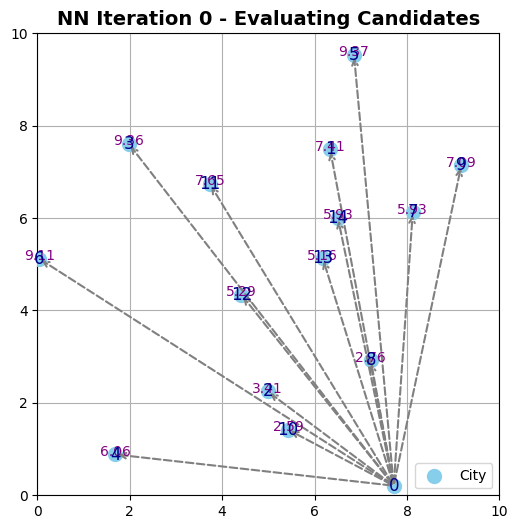

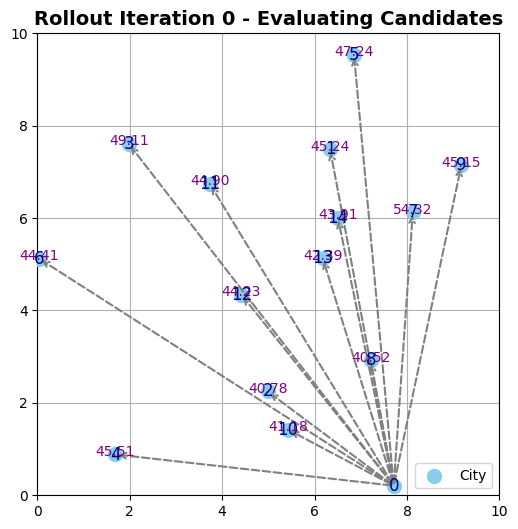

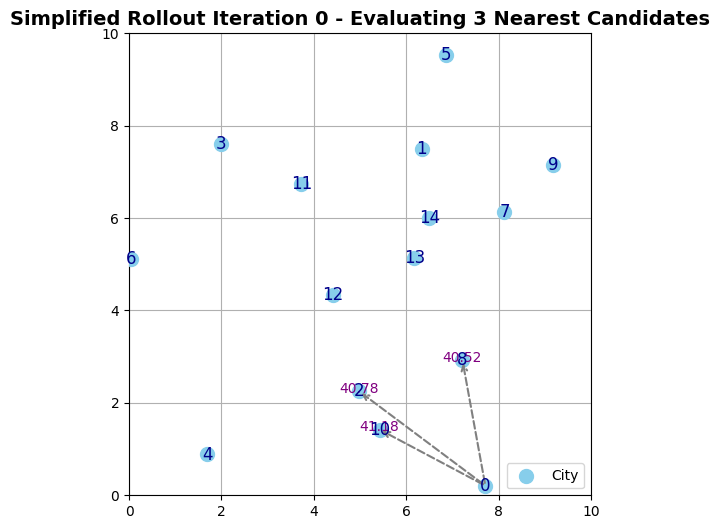